In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy.integrate import solve_ivp
import pickle

In [2]:
header = {
    "seed": 42,
    "scipy_version": scipy.__version__,
    "numpy_version": np.__version__,
}
header

{'seed': 42, 'scipy_version': '1.15.3', 'numpy_version': '1.26.4'}

Things to consider:
- Each equation has several parameters that can be adjusted to create different behavior
- The initial condition governs some of the differences between different systems

## Dynamical Systems

In [3]:
def harmonic_oscillator(t, y, omega):
    x, v = y
    return np.array([v, -omega**2 * x])

def damped_harmonic_oscillator(t, y, zeta, omega):
    x, v = y
    return [v, -2 * zeta * omega * v - omega**2 * x]

def sm_damper_forcing(t, y, zeta, omega, gamma, alpha):
    x, v = y
    return [v, -2 * zeta * omega * v - omega**2 * x + gamma * np.cos(alpha * x)]

def duffing_oscillator(t, y, zeta, omega, beta, gamma, alpha):
    x, v = y
    return [v, -2 * zeta * omega * v - omega**2 * x - beta * x**3 + gamma * np.cos(alpha * x)]

def van_der_pol(t, y, mu):
    x, v = y
    return [v, mu * (1 - x**2) * v - x]

In [4]:
def harmonic_params(rng):
    params = {
        'omega' : rng.uniform(1,10)
    }
    return params

def under_damped_harmonic_params(rng):
    params = {
        'zeta' : rng.uniform(0.1,0.9),
        'omega' : rng.uniform(1,10)
    }
    return params

def over_damped_harmonic_params(rng):
    params = {
        'zeta' : rng.uniform(1.05,1.5),
        'omega' : rng.uniform(1,10)
    }
    return params

def sm_under_damper_forcing_params(rng):
    params = {
        'zeta' : rng.uniform(0.1,0.9),
        'omega' : rng.uniform(1,10),
        'gamma' : rng.uniform(0.2,2),
        'alpha' : rng.uniform(0.5,10),
    }
    return params

def sm_over_damper_forcing_params(rng):
    params = {
        'zeta' : np.random.uniform(1.05,1.5),
        'omega' : np.random.uniform(1,10),
        'gamma' : np.random.uniform(0.2,2),
        'alpha' : np.random.uniform(0.5,10),
    }
    return params

def duffing_params(rng):
    params = {
        'zeta' :  rng.uniform(1.05,1.5),
        'omega' : rng.uniform(1,10),
        'beta' :  rng.uniform(0.1,5),
        'gamma' : rng.uniform(0.2,2),
        'alpha' : rng.uniform(0.5,10),
    }
    return params

def van_der_pol_params(rng):
    params = {
        'mu' : rng.uniform(0.1,5)
    }
    return params

In [108]:
harm_d = 2
damped_harm_d = 2
sm_damp_d = 2
duffing_d = 2
van_der_pol_d = 2

In [109]:
systems = {'harmomic_oscillator' : (harmonic_oscillator, harmonic_params, harm_d),
           'under_damped_harmonic_oscillator' : (damped_harmonic_oscillator, under_damped_harmonic_params, damped_harm_d),
           'over_damped_harmonic_oscillator' : (damped_harmonic_oscillator, over_damped_harmonic_params, damped_harm_d),
           'spring_mass_under_damper_with_forcing' : (sm_damper_forcing, sm_under_damper_forcing_params, sm_damp_d),
           'spring_mass_over_damper_with_forcing' : (sm_damper_forcing, sm_over_damper_forcing_params, sm_damp_d),
           'duffing_oscillator' : (duffing_oscillator, duffing_params, duffing_d),
           'van_der_pol_oscillator' : (van_der_pol, van_der_pol_params, van_der_pol_d)
          }

In [110]:
def create_dataset(n,start,end,num_series,seed=42):
    rng = np.random.default_rng(seed)
    
    t_eval = np.linspace(start,end,n)
    dataset = {system : [] for system in systems.keys()}
    
    for system, (ode, sampler, dim) in systems.items():
        for _ in range(num_series):
            y0 = [rng.uniform(-5,5), rng.uniform(-5,5)]
            params = sampler(rng)
            
            def wrapped_ode(t,y): return ode(t,y,**params)
        
            sol = solve_ivp(wrapped_ode, [start,end], y0, t_eval=t_eval)
        
            record = {
                'params' : params,
                'y0' : y0,
                'start' : start,
                'end' : end,
                't' : sol.t,
                'y' : sol.y
            }
        
            dataset[system].append(record)

    return dataset

In [111]:
n = 1000
begin = 0
end = 5
num_series = 100
seed = 42

dataset = create_dataset(n,begin,end,num_series,seed=42)

In [112]:
len(systems)

7

In [113]:
path = rf"data\1-dimensional-systems\dataset_{len(systems)}_class_{num_series}_samples.pkl"

with open(path, 'wb') as f:
    pickle.dump(dataset, f)

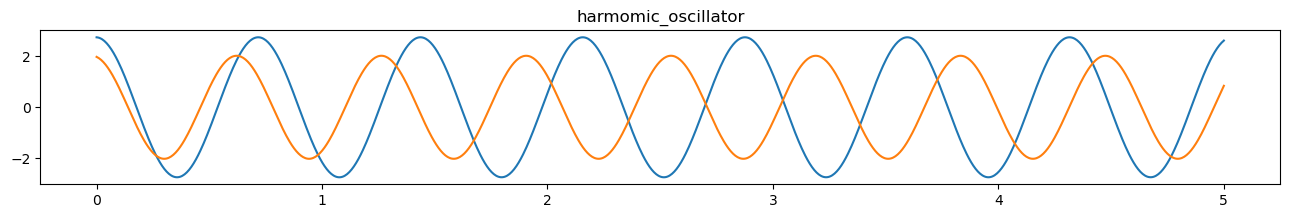

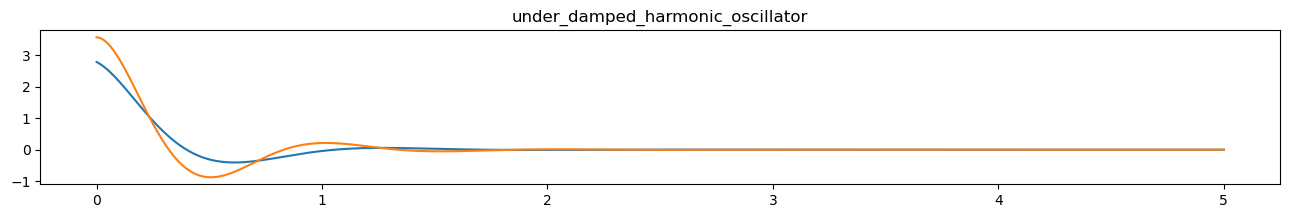

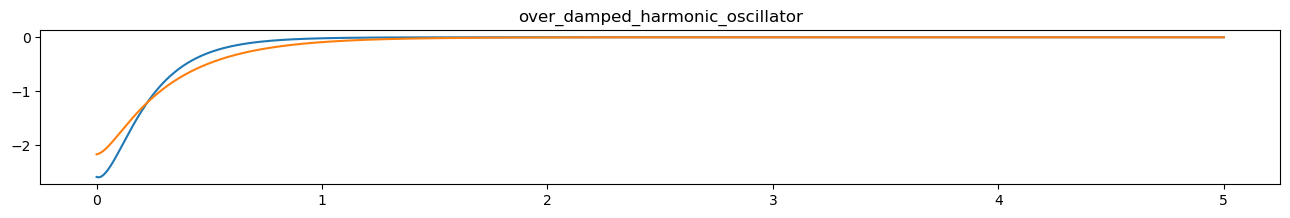

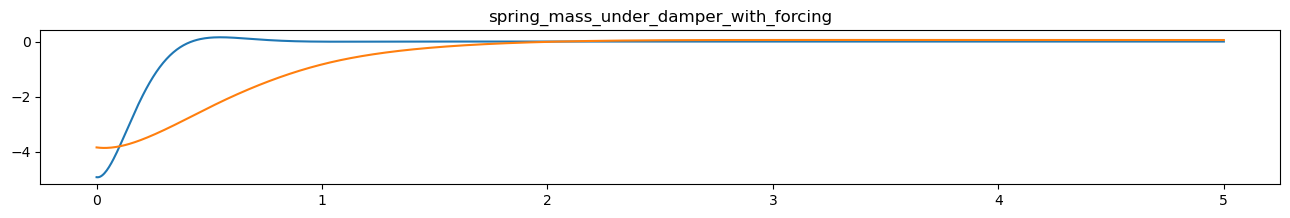

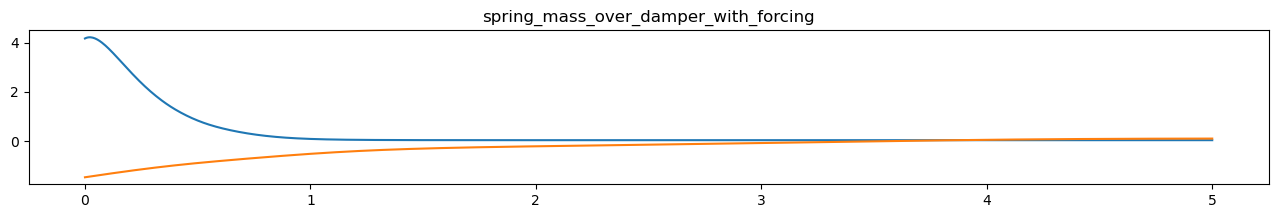

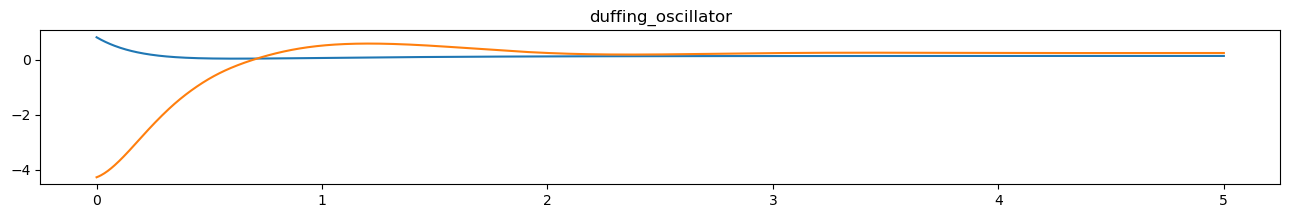

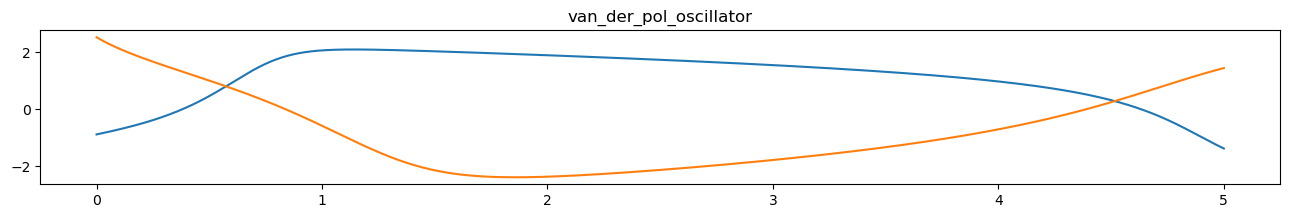

In [118]:
for key in dataset.keys():

    curr_data = dataset[key]
    
    plt.figure(figsize=(16,2))
    for i in range(2):
        x = curr_data[i]['t']
        y = curr_data[i]['y'][0,:].T
        plt.plot(x,y)

    plt.title(key)
    # plt.legend(['x','v'])
    plt.show()